# Increasing the chances of your speech to go viral: an interrogation on what helps catch the attention of modern day fickle newsreaders 

## Context

We will try to use the Quotebank dataset complemented with informations collected from Wikidata to answer the question of which factors contribute to a quote from a person going "viral" in the news.

We define a quote as viral if the number of times the quote was repeated exceeds a certain threshold, which we will choose to be 100 in Section [What is a Viral Quote?](#what_is_a_viral_quote). 

Before diving into the question, we will start by exploring the data extracted from both datasets: Quotebank and Wikidata. The first thing we'll do is analyzing the number of occurences of the quotes present in Quotebank and define the notion of virality. After that, we will try to find the relevant features that can have an impact on the virality of the quote. We will look both at characteristics of the speakers as well as of the quote text itself. With these features, we will build, train and cross-validate a model to try predicting the virality of a quote given the set of the extracted features.

## <a id='table_of_contents'></a> Table of Contents:
1. [Exploratory Data Analysis](#exploratory_data_analysis)
    1. [Summarizing the data into a tractable dataframe](#summarizing_data_into_tractable_dataframe)
    2. [What is a Viral Quote?](#what_is_a_viral_quote)
    3. [Speakers' Features](#speaker_features)
        1. [Age](#age)
        2. [Gender](#gender)
        3. [Occupation](#occupation)
        4. [Nationality](#nationality)
        5. [Ethnicity](#ethnicity)
        6. [Religion](#religion)
        7. [Heatmaps: Look for features co-occurence](#heatmap)
        8. [Overall Number of Quotes with Missing Speaker Information](#overall) 
    4. [Extraction and Visualization of the Quote Topics](#extraction_visualization_quote_topics)

2. [Training of Classifier](#training_classifier)
    1. [Generating Training Samples and Labels](#generate_samples_labels)

# TO DO





## Datasets

### The Quotebank Dataset

The Quotebank dataset ...............



This dataset contains the following information:

Quotation-centric data:
- `quoteID`: Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}").
- `quotation`: Text of the longest encountered original form of the quotation.
- `date`: Earliest occurrence date of any version of the quotation.
- `phase`: Corresponding phase of the data in which the quotation first occurred (A-E).
- `probas`: Array representing the probabilities of each speaker having uttered the quotation.
     The probabilities across different occurrences of the same quotation are summed for each distinct candidate speaker and then normalized.
- `proba`: Probability for a given speaker.
- `speaker`: Most frequent surface form for a given speaker in the articles where the quotation occurred.
- `speaker`: Selected most likely speaker. This matches the the first speaker entry in `probas`.
- `qids`: Wikidata IDs of all aliases that match the selected speaker.
- `numOccurrences`: Number of time this quotation occurs in the articles.
- `urls`: List of links to the original articles containing the quotation. 

This comes directly from the following website : [site](https://zenodo.org/record/4277311). Do not hesitate to use it if more details on the data are needed, as well as this [paper](https://dlab.epfl.ch/people/west/pub/Vaucher-Spitz-Catasta-West_WSDM-21.pdf).

As a note, there are two ways to represent the data in this dataset, but the quotation-centric representation was the one that interested us the most for our research.



### The Wikidata Dataset

The Wikidata dataset ...............

Wikidata uses [Identifiers](https://www.wikidata.org/wiki/Wikidata:Identifiers) (which we will refer to for the rest of the notebook as Query IDs, or QIDs) to name assign a unique name to its objects.

For each speaker, we will be querying and using the following informations:
- `Gender`: Gender of the speaker, is usually male, female or None (non specified) 
- `Occupations`:
- `Date of Birth`:
- `Nationality`:
- `Religion`:
- `Ethnicity`:
- ???




# TO DO











For more informations about this data, you can read about it in its [site](https://www.wikidata.org/wiki/Wikidata:Main_Page).

#### Imports and Constants Definitions

In [4]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import itertools
from collections import Counter
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import utils
import feature_extraction
import plot

In [5]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')

<a id='exploratory_data_analysis'></a>
# 1. Exploratory data analysis

<a id='summarizing_data_into_tractable_dataframe'></a>
## 1.A. Summarizing the data into a tractable dataframe
[Back to table of content](#table_of_contents)

In this section, we will be parsing the Quotebank dataset row by row and, with the help of the information about the speaker which we extracted from Wikidata, we will summarize it into a dataframe with the following columns:

- `Index`: the Wikidata QID associated to the each speaker contained in the Quotebanks dataset. One row with value None will aggregate all quotes for which the speaker is unknown.


- `quote_count`: the number of different quotes the speaker has been attributed in the Quotebanks dataset. This value is always a strictly positive integer.


- `age`: the average age of the speaker when he said each of the quotes assigned to it. We accepted to aggregate these values as an average for the data exploration step because the dataset only spans 5 years and we can consider that a negligible difference compared to the large age differences which we expect to observe between different speakers. This value can be NaN if the birth date of the speaker is unknown, as that prevents us from calculating age.


- `num_occurrences`: the total number of times any of the quotes assigned to the speaker has been repeated in a different news article. This value is always a strictly positive integer.


- `gender`: the gender that Wikidata assigns to the speaker. This value can be None if no gender is assigned to the speaker, is a list of one item if a unique gender is assigned to the speaker and a list with multiple items if multiple genders are assigned to the speaker (such as for transexual people).


- `occupation`: a list of occupations that Wikidata assigns to the speaker. This value can be None if no occupations are assigned to the speaker, otherwise it is always a list with at least one element.


- `nationality`: a list of nationalities that Wikidata assigns to the speaker. This value can be None if no nationalities are assigned to the speaker, otherwise it is always a list with at least one element.


- `ethnic_group`: a list of ethnicities that Wikidata assigns to the speaker. This value can be None if no ethnicities are assigned to the speaker, otherwise it is always a list with at least one element.


- `religion`: a list of religions that Wikidata assigns to the speaker. This value can be None if no ethnicities are assigned to the speaker, otherwise it is always a list with at least one element.

In [6]:
@utils.cache_to_file_pickle("function-dataset_stats", cache_dir = CACHE_DIR)
def dataset_stats(data_dir, speaker_info_file_path):
    """
    Function for summarizing Quotebank dataset (with the help of Wikidata dataset) into a tractable dataframe.
    
    Params:
        data_dir::[str]
            Path of the directory containing the Quotebank dataset for each year as a separate .json.bz2 file.
        speaker_info_file_path::[str]
            Path for the speaker_attributes.parquet file (containing part of the informations collected from
            Wikidata about the speakers).
            
    Returns:
        num_quotes_count::[int]
            The total number of different quotes contained in the Quotebank dataset.
        num_occurrences_counts::[dict]
            Dictionary used as counter for the frequency with which the number of occurrences (used as key of the dictionary)
            occurs in the Quotebank dataset (count of each key is the corresponding value in the dictionary).
        speakers_info::[pd.DataFrame]
            DataFrame containing informations of each speaker in Quotebank dataset:
            quote_count, age, num_occurrences, gender, occupation, nationality, ethnic_group, religion.
    
    """
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = data_dir, 
                                                                            speaker_info_file_path = speaker_info_file_path)
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, 
                                                        columns = ['id', 'date_of_birth', 'gender', 'occupation',
                                                                   'nationality', 'ethnic_group', 'religion'])
    
    # Initialization of dictionaries for extracting meaningful features.
    num_quotes_count = 0
    num_occurrences_counts = {}
    speakers_info = {}
    
    for line in utils.json_lines_generator(data_dir):        
        num_quotes_count += 1
        
        line_num_occurrences = line['numOccurrences']
        num_occurrences_counts[line_num_occurrences] = num_occurrences_counts.get(line_num_occurrences, 0) + 1
        
        # Solve ambiguities in speaker qids due to homonyms.
        speaker = feature_extraction.solve_ambiguous_speakers(line['qids'], linkcounts)
        
        # Calculate speaker age. In case of missing value, None is used.
        speaker_birth_date = speaker_data.get(speaker, {}).get('date_of_birth', None)
        speaker_age = feature_extraction.get_speaker_age(speaker_birth_date, line['date'])
        
        # Add to the dictionary the number of quotes, the age and the number of occurences of the quotes for current speaker.
        # If necessary, make a new key for the current speaker in dictionary.
        if speaker in speakers_info:
            speakers_info[speaker]['quote_count'] += 1
            speakers_info[speaker]['age'].append(speaker_age)
            speakers_info[speaker]['num_occurrences'] += line_num_occurrences
        else:
            speakers_info[speaker] = {'quote_count': 1,
                                      'age': [speaker_age],
                                      'num_occurrences': line_num_occurrences}
            
            # If the speaker was not already in the dictionary, retrieve its gender, occupation, nationality, 
            # ethnic group and religion and add it to speaker_info. 
            # Before adding the information to the speaker_info dictionary, convert them from Wikidata QIDs to readable
            # english labels. If the information is not available (because speaker is unknown, that information for that
            # speaker is not available or the label of that information for that speaker is not available), None is added 
            # to the dictionary.
            for info_key in ['gender', 'occupation', 'nationality', 'ethnic_group', 'religion']:
                speaker_value = speaker_data.get(speaker, {}).get(info_key, None)
                speaker_value_labels = []
                if speaker_value is not None:
                    for qid in speaker_value:
                        label = qid_labels.get(qid, None)
                        if label is not None:
                            speaker_value_labels.append(label)

                speaker_value_labels = speaker_value_labels if len(speaker_value_labels) != 0 else None
                speakers_info[speaker][info_key] = speaker_value_labels
                
    # Convert the speaker_info dictionary into a dataframe and aggregate the ages of each speaker by averaging
    # across its quotes.
    speakers_info = pd.DataFrame(speakers_info).T
    speakers_info['age'] = speakers_info['age'].apply(lambda l: None if all(elem is None for elem in l) else np.mean(l))
    
    return num_quotes_count, num_occurrences_counts, speakers_info


# Load the Quotebank and speaker_attribute dataset, extract the relevant infos for each speaker and generate a 
# tractable dataframe containing meaningful features.
num_quotes_count, num_occurrences_counts, speakers_info = dataset_stats(data_dir = DATA_DIR, 
                                                                        speaker_info_file_path = SPEAKER_INFO_FILE_PATH)

In [9]:
print(f"There are {num_quotes_count} quotes in the Quotebank dataset.")

There are 115584257 quotes in the Quotebank dataset.


In [10]:
print(f"For {speakers_info.loc[speakers_info.index.isna(), 'quote_count'].sum() / num_quotes_count:.2%} of quotes the speaker is unknown.")

For 34.60% of quotes the speaker is unknown.


In [11]:
if speakers_info.isin([[]]).any().any():
    raise ValueError("Cells containing only empty list were detected in speaker_info dataframe!")
else:
    print("No cells containing only empty list were detected in speaker_info dataframe :)")

No cells containing only empty list were detected in speaker_info dataframe :)


<a id='what_is_a_viral_quote'></a>
## 1.B. What is a Viral Quote?
[Back to table of content](#table_of_contents)

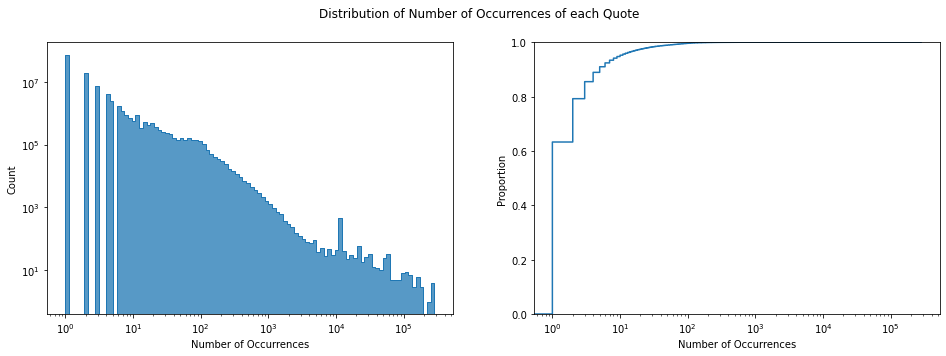

In [12]:
# Visualization of the distribution of number of occurences for each quote in the dataframe.
fig, axes = plt.subplots(1, 2, figsize = (16, 5))
df_num_occurrences_counts = pd.DataFrame(num_occurrences_counts.items(), columns = ['Number of Occurrences', 'Count'])
sns.histplot(df_num_occurrences_counts, x = 'Number of Occurrences', weights = 'Count',
             bins = 100, log_scale = (True, True), element = "step", ax = axes[0])
sns.ecdfplot(df_num_occurrences_counts, x = 'Number of Occurrences', weights = 'Count',
             log_scale = (True, False), ax = axes[1])
plt.suptitle("Distribution of Number of Occurrences of each Quote")
plt.show()

# Cleanup cell temporary variables.
del df_num_occurrences_counts

In [13]:
print("Statistics of Number of Occurrences of each Quote:\n")
print(utils.describe_weighted_stats(num_occurrences_counts.keys(), num_occurrences_counts.values(),
                                    percentiles = [0.95, 0.97, 0.99, 0.995, 0.999]).to_string(float_format = '{:.10g}'.format))

Statistics of Number of Occurrences of each Quote:

count     115584257
mean    3.992644967
std     113.8343316
min               1
25.0%             1
50.0%             1
75.0%             2
95.0%            10
97.0%            17
99.0%            55
99.5%            90
99.9%           215
max          282552


In [14]:
# Define a viral quotes as a quotes that has at least 100 occurences.
VIRAL_THR = 100

num_cited_more_thr = sum(value for key, value in num_occurrences_counts.items() if key >= VIRAL_THR)
num_cited_less_thr = sum(value for key, value in num_occurrences_counts.items() if key < VIRAL_THR)

print(f"{num_cited_less_thr/(num_cited_less_thr + num_cited_more_thr):.3%} of quotes are quoted less than {VIRAL_THR} times")
print(f"Quotes cited {VIRAL_THR} times or more:", num_cited_more_thr)
print(f"Quotes cited less than {VIRAL_THR} times:", num_cited_less_thr)

# Cleanup cell temporary variables.
del num_cited_more_thr, num_cited_less_thr

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


<a id='speaker_features'></a>
## 1.C. Speakers' Features
[Back to table of content](#table_of_contents)

<a id='age'></a>
### 1.C.a. Age

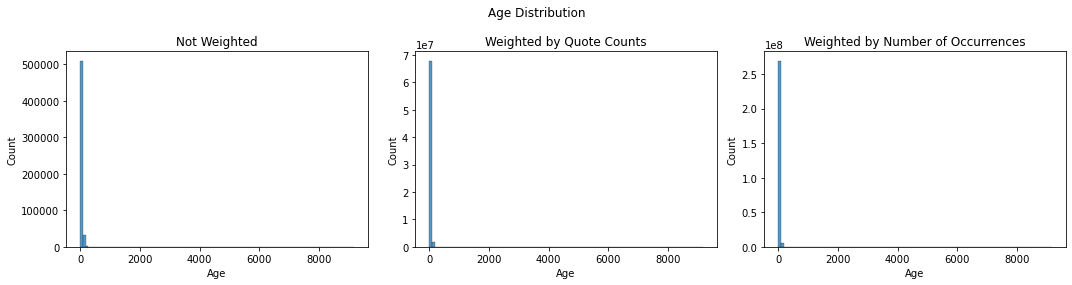

In [15]:
plot.plot_speaker_feature_distribution(speakers_info, 'age', bins = 100, figsize = (15, 4))

In [16]:
print("Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):\n")

print(speakers_info['age'].describe().to_string(float_format = '{:.6g}'.format))

Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):

count     543213
mean     54.3409
std      50.0288
min     -4.90909
25%           36
50%           52
75%           67
max      9168.28


As we can see from the above plots and computed statistics, we have some extremely large values for the age. These values are due to quotes being attributed to people being long dead at the time of the quote. We can observe that some speakers are assigned negative ages, which is the result of an incorrect assignement of the birth date in Wikidata, or of an incorrect assignement of the speaker in our algorithm which solves for homonyms.

To deal with both cases, we will limit ourselves to ignoring quotes coming from people which have a calculated age of less than 5 years or more than 95 years. Note that a better approach may be to query Wikidata for whether the person is dead, but we don't expect this result to be significantly different. We can afford to discard these quotes because they represent a very tiny minority of the data, but even more importantly because they would not bring any valuable insight into the question at hand, as that concerns people that at the time of the quote were adults or young adults which benefited from media coverage.

Focusing only on the desired range of ages, we get the results in the next cells.

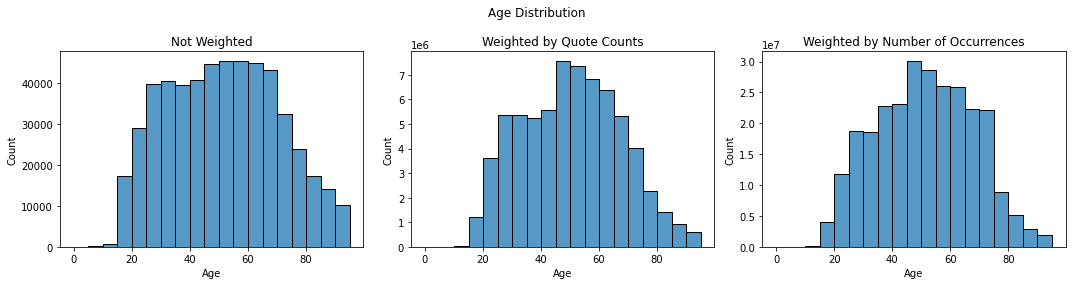

In [17]:
plot.plot_speaker_feature_distribution(speakers_info, 'age', bins = range(0, 100, 5), figsize = (15, 4))

In [18]:
print("Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):\n")

print(speakers_info.loc[(speakers_info['age'] >= 5) & (speakers_info['age'] <= 95), 'age'].describe().to_string(float_format = '{:.6g}'.format))

Statistics of Age of each Speaker (not weighted by quote counts or occurrences counts):

count    528634
mean     51.329
std     19.1956
min           5
25%     35.4608
50%     51.1883
75%     65.9729
max          95


In [19]:
ages = speakers_info[['age', 'quote_count']]
print(f"{(ages['age'].isna() * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker for which age couldn't be determined.")
ages = ages.dropna()
print(f"{((ages['age'] < 5 ) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker with an age smaller than 5.")
print(f"{((ages['age'] > 95) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker an age larger than 95.")

39.59676% quotes have speaker for which age couldn't be determined.
0.00724% quotes have speaker with an age smaller than 5.
1.05245% quotes have speaker an age larger than 95.


As we can see from these results, 50% of the speakers in our dataset have ages lying between 19 and 66, with the median being at 51. These results coincide with what we expected: the speakers benefitting from media coverage are mainly young adults and middle-aged men (only a minority are children or elderly people).

We also see that for almost 40% of quotes the age of the speaker couldn't be determined, and hence these quotes will not be used when training our models. It should be noted that this value also includes the 34.60% of quotes for which the speaker is completely unknown.

Finally, we can observe that the distribution changes when weighting by the number of quotes and number of occurrences compared to when not weighting. This suggests that the distribution of ages for people which have been quoted at least once in their lives by any newspaper is quiet uniform between 25 and 70 years of age, but the distribution of people which are frequently cited and for which every citation is repeated several times is more concentrated between the ages of 35 to 75.

<a id='gender'></a>
### 1.C.b. Gender

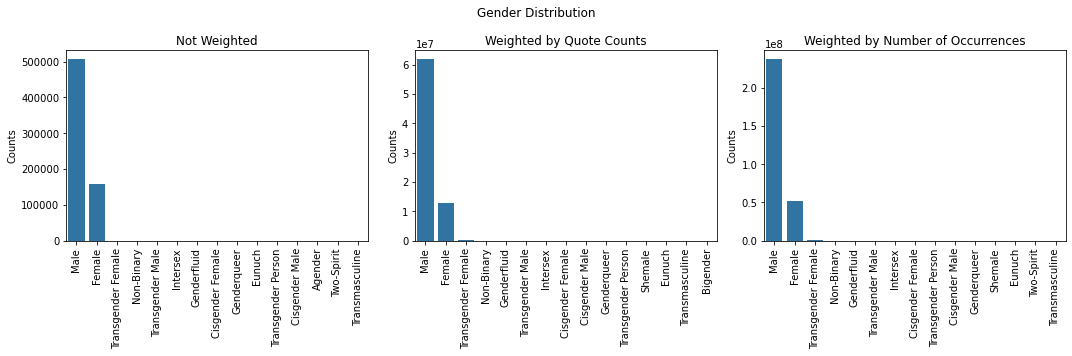

In [20]:
plot.plot_speaker_feature_distribution(speakers_info, 'gender', n_bars = 15, figsize = (15, 5))

In [21]:
print(f"{(speakers_info['gender'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined.")
print(f"{speakers_info['gender'].isin([['Male'], ['Female']]).sum() / (~speakers_info['gender'].isna()).sum():.5%} of speakers are either Male or Female.")

35.38079% quotes have speaker for which gender couldn't be determined.
99.88410% of speakers are either Male or Female.


As we can see from these results, the vast majority of speakers is either male or female. for this reason, in later parts of the jupyter the possible genders will be grouped into 3 classes: male, female or other.

We also see that for a little more than 35% of quotes the gender of the speaker couldn't be determined, and hence these quotes will not be used when training our models. It should be noted that this value also includes the 34.60% of quotes for which the speaker is completely unknown.

Finally, we can observe that the distribution changes when weighting by the number of quotes and number of occurrences compared to when not weighting. This change suggests that males are quoted more often by the media, and their quotes are repeated more times than females. 

<a id='occupation'></a>
### 1.C.c. Occupation

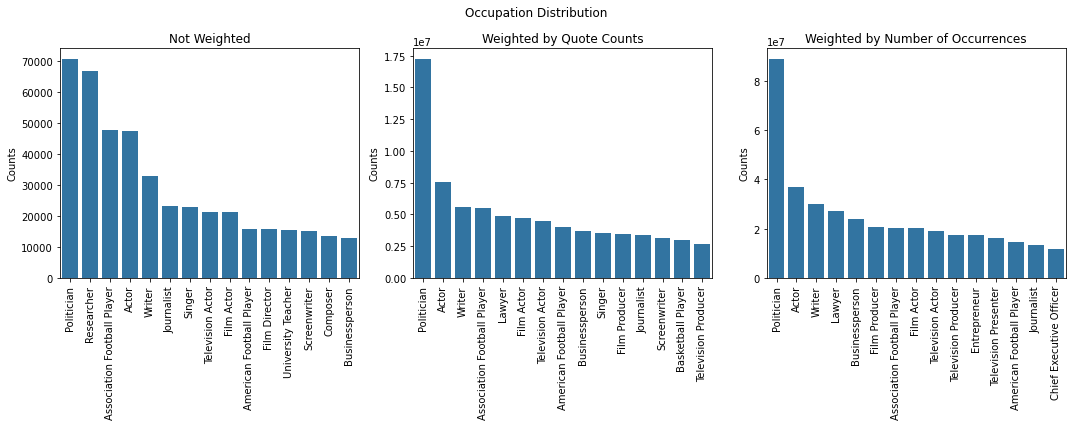

In [22]:
plot.plot_speaker_feature_distribution(speakers_info, 'occupation', n_bars = 15, figsize = (15, 6))

In [23]:
print(f"{(speakers_info['occupation'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which occupation couldn't be determined.")

36.31932% quotes have speaker for which occupation couldn't be determined.


As expected, there are three main professions which are present in newspaper quotes : \
(1) Politicians: Since the dataset is based on newspapers it makes a lot of sense that they are the most quoted. The majority of quotes originate from this profession and that is even more visible in Quote count or Number of occurences distributions. \
(2)The sport related professions. Which again makes a lot of sense because every newspaper has a dedicated sport section.\
(3) A mix of litterate professions (actors, journalists etc...) and Business. 

The most relevant thing to extract from this graph is that politicians and researchers occupy huge amounts of the quotespace which is great for us since they are the main recipients of our research questions.

<a id='nationality'></a>
### 1.C.d. Nationality

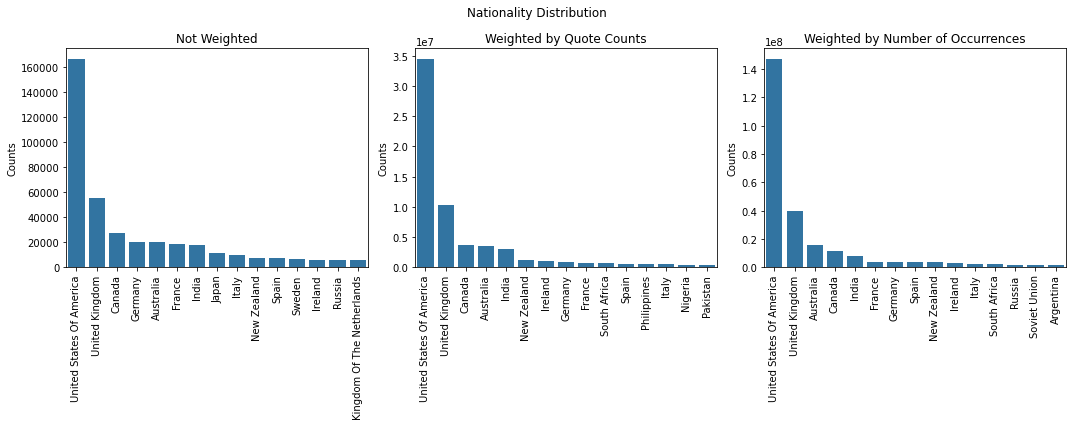

In [24]:
plot.plot_speaker_feature_distribution(speakers_info, 'nationality', n_bars = 15, figsize = (15, 6))

In [25]:
print(f"{(speakers_info['nationality'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which nationality couldn't be determined")

41.66662% quotes have speaker for which nationality couldn't be determined


We observe an over representation of english speaking countries. The Quobert dataset is build only on english news so this is not surprising. This does mean that this feature is extremely biased and can't be used to conclude anything.

On a funny sidenote, The cold war is such an important subject even today that the "Soviet Union" is still represented in number of occurences distribution as one of the top nationalities. Let's not forget that quotations are not only a representation of the distribution of individuals in a nation and their popularity but also of events past and present. 

<a id='ethnicity'></a>
### 1.C.e. Ethnicity

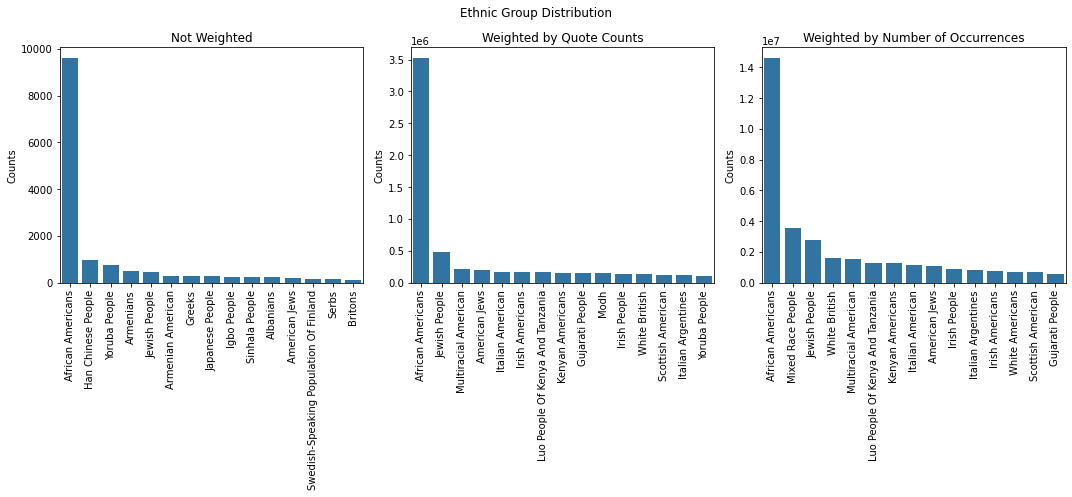

In [26]:
plot.plot_speaker_feature_distribution(speakers_info, 'ethnic_group', n_bars = 15, figsize = (15, 7))

In [27]:
print(f"{(speakers_info['ethnic_group'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which ethnic_group couldn't be determined")

93.97344% quotes have speaker for which ethnic_group couldn't be determined


Most important thing to note, the information we have comes from an extremely small chunk of the dataset. Only 6% of speakers have a known ethnic origin. A bias could also have been introduced from the fact that a major part of the population is not aware of their actual origins, especially americans, while african-american communities, armenians etc have a strong identity sense which leads them to fill out the information. So we consider this data to be highly volatile, non representative, and unexploitable. The other two distributions look more or less the same as the first one so there is no information to be extracted there also.

Interestingly, one category leaps up the rankings when considering number of quotes/occurences : Multiracial americans. Obama being registered in wiki data as a member of this category might explain this leap in representation. 

<a id='religion'></a>
### 1.C.f. Religion

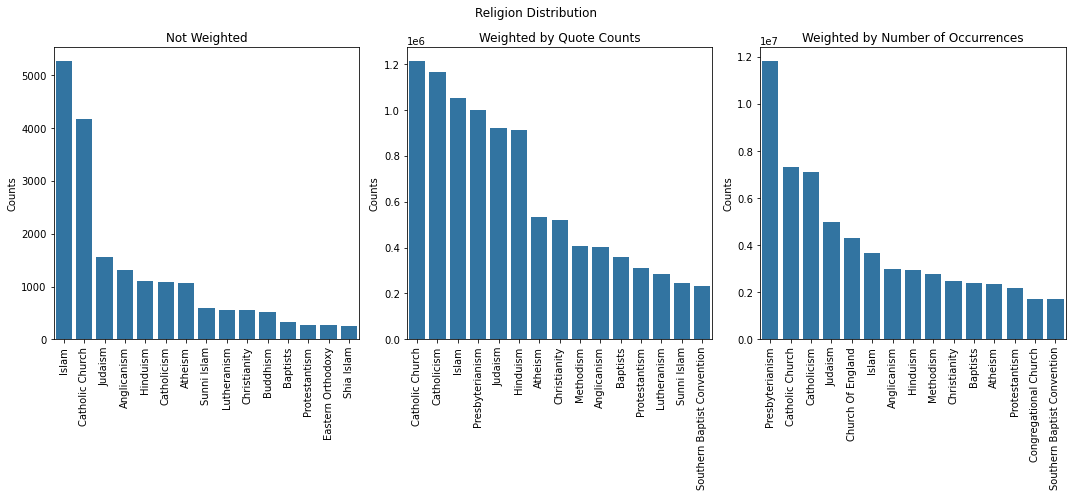

In [28]:
plot.plot_speaker_feature_distribution(speakers_info, 'religion', n_bars = 15, figsize = (15, 7))

In [29]:
print(f"{(speakers_info['religion'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which religion couldn't be determined")

90.28355% quotes have speaker for which religion couldn't be determined


Only a slice of 10% of our  speaker catalogue provides information on their religion. As we have noticed previously, this distribution should skew towards being the distribution of english speaking countries and in particular that of America. 

There are a lot of "American based" religions appearing in the distribution which are all variations of the Catholic Church. It might seem like Islam is the most represented religion in Non weighted but summing "Catholic Church" "Catholicism" and "Christianity" makes it the second most practiced represented religion which makes sense.
Quote count and Occurences show us that media is more enclined to quote Catholic based churches and we point out again that we see this distribution of english based countries with "church of england", "anglicanism" "hinduism" appearing through the distributions especially the occurences.


<a id='heatmap'></a>
### 1.C.g. Heatmaps: Look for features co-occurence

In [12]:

def plot_heatmaps(data,feature1,feature2,weight='quote_count'):
    
    co_occurrence_counter=Counter()
    matrix_counts={}
    
    if feature1 == feature2:
        df = pd.DataFrame(data[feature1].dropna(axis = 0, how = 'any'))
        for _, row in df.iterrows():
            co_occurrence_counter.update(Counter(list(itertools.combinations(row[feature1], 2))))
        
        ser = pd.Series(list(co_occurrence_counter.values()),index=pd.MultiIndex.from_tuples(co_occurrence_counter.keys()))
        df = ser.unstack()
        df.head()
        plt.figure(figsize = (14, 8))
        sns.heatmap(df)
        plt.title("Heatmap of co-occurrences between "+ feature1 + " and "+ feature2, pad=20)
    else:
        df = data[[feature1, feature2, weight]].dropna(axis = 0, how = 'any')
        for _, row in df.iterrows():
            for value1 in row[feature1]:            
                if value1 not in matrix_counts:
                    matrix_counts[value1] = {}
                for value2 in row[feature2]:
                    if value2 not in matrix_counts[value1]:
                        matrix_counts[value1][value2]=0
                    matrix_counts[value1][value2] += row[weight]
                    
                    
        df=pd.DataFrame(matrix_counts)
        plt.figure(figsize = (14, 8))
        sns.heatmap(df,norm=LogNorm())
        plt.title("Heatmap of Quote Counts between "+ feature1 + " and "+ feature2, pad=20)
        
    plt.xlabel(feature1.title())
    plt.ylabel(feature2.title())
    plt.show()

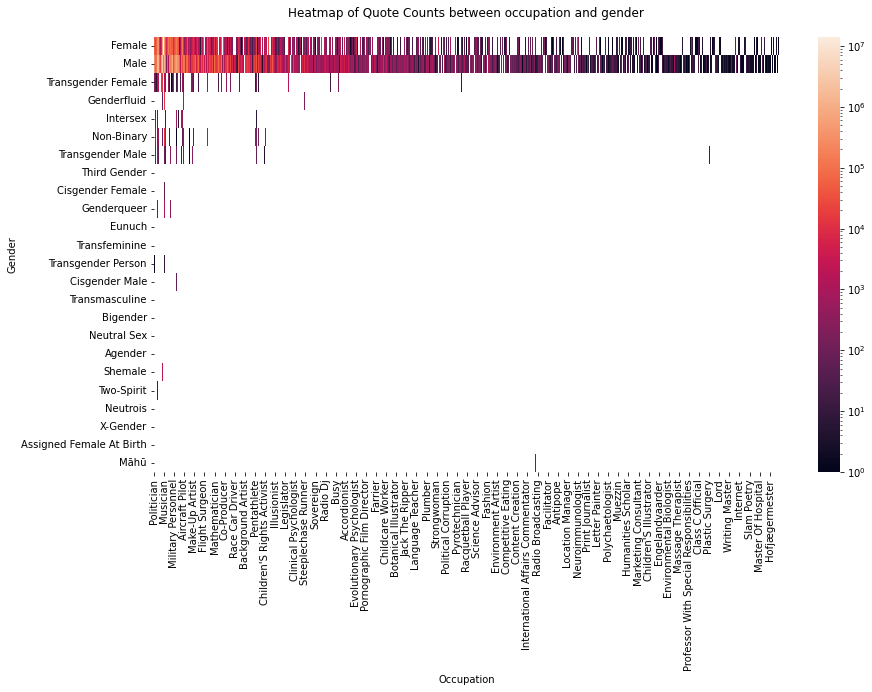

In [13]:
plot_heatmaps(speakers_info,'occupation','gender','quote_count')

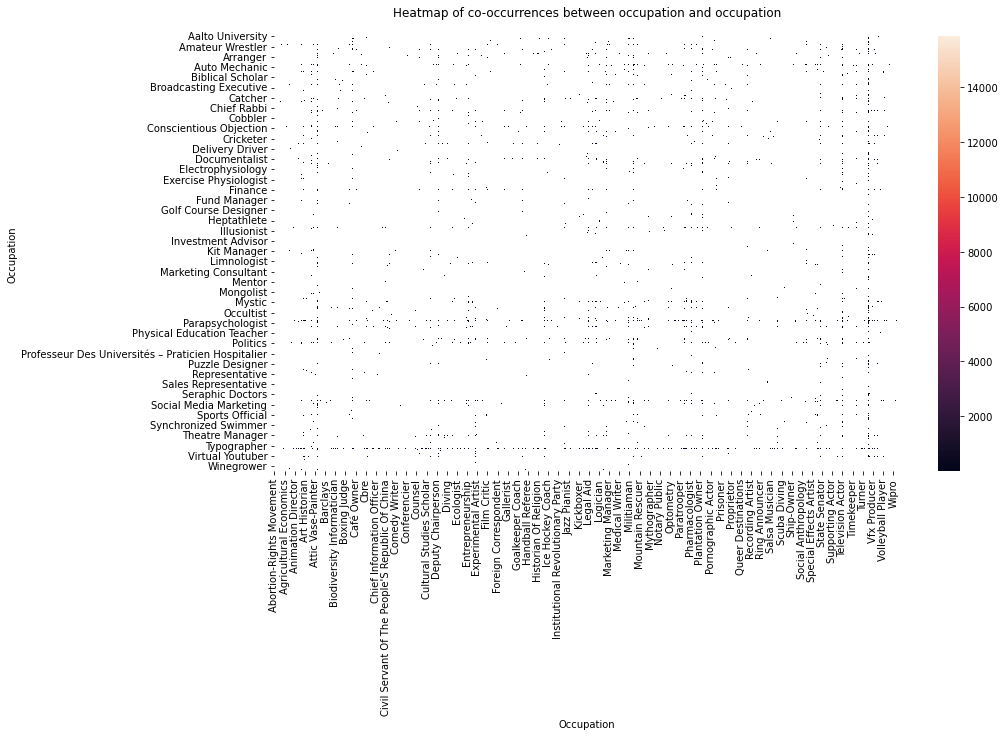

In [14]:
plot_heatmaps(speakers_info,'occupation','occupation')

<a id='overall'></a>
### 1.C.h. Overall Number of Quotes with Missing Speaker Information

In [30]:
features_we_are_going_to_use = ['age', 'gender', 'occupation']

print(f"{(speakers_info[features_we_are_going_to_use].isna().any(axis = 1) * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker information missing.")

40.41783% quotes have speaker information missing


# TO DO: WRITE DISCUSSION AS EARLIER

We chose to discard these quotes with missing speaker info from our dataset because it still leaves up with more than 60 million quotes to train on which is more than enough.

<a id='extraction_visualization_quote_topics'></a>
## 1.D. Extraction and Visualization of the Quote Topics
[Back to table of content](#table_of_contents)

https://github.com/MaartenGr/BERTopic

No training: https://github.com/MaartenGr/KeyBERT or https://github.com/LIAAD/yake

In [ ]:
from random import randrange

from bertopic import BERTopic

In [ ]:
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")
BERT_MODEL_SAVE_PATH = os.path.join(CACHE_DIR, 'bert_model')

In [ ]:
def preprocess_dataset(data_dir, output_file_path, speaker_info_file_path,
                       can_reuse_output = True):
    if os.path.isfile(output_file_path) and can_reuse_output:
        return
    
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)
    
    # Load part of data extracted from Wikidata dump about speakers.
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, columns = ['id', 'date_of_birth', 'gender', 'occupation'])
    
    with bz2.open(output_file_path, "wb") as output_file:
        
        for line in utils.json_lines_generator(data_dir):
                
            # Preprocess line features from line.
            preprocessed_line = feature_extraction.preprocess_line(line, speaker_data, qid_labels, linkcounts)
            
            # Ignore lines for which feature extraction failed due to unavailability of information or
            # due to filtering of extreme values.
            if preprocessed_line is None:
                continue
            
            # Store features of line.
            output_file.write((json.dumps(features) + '\n').encode('utf-8'))

In [ ]:
preprocess_dataset(DATA_DIR,
                   PREPROCESSED_DATASET_FILE_PATH,
                   SPEAKER_INFO_FILE_PATH,
                   can_reuse_output = True)

In [ ]:
def get_trained_bert_model(preprocessed_dataset_file_path, downsampling_factor = 100, calculate_probabilities = False, min_topic_size = 50, nr_topics = "auto"):
    
    # Training on all the quotes in the whole dataset is unfeasible on a 16 GB of RAM machine.
    # Hence we do two things to decrease the number of quotes used for training:
    # we only keep relevant quotes by selecting those corresponding to speakers we are interested in,
    # as explained in feature_extraction.extract_speaker_features, and we randomly sample a subset
    # of the data. The first thing was already done when generating preprocessed_dataset_file_path.
    quotes_subset = []
    for line in utils.json_lines_generator(preprocessed_dataset_file_path):
        if not randrange(0, downsampling_factor):
            quotes_subset.append(line['quotation'])
        
    print("Training on", len(quotes_subset), "quotes")
        
        
    # Min topics size should be fine-tuned: we have very large dataset hence a value of ~1000 is better than default one.
    # Also, may want to play with nr_topics: either leave it to default none, or auto, or set a manual value large enough
    # that topics do not get mixed up while merging. Also note it is heavy to run anything other than None.
    # In background, BERTopic uses UMAP, HDBSCAN, CountVectorizer. Each has their set of parameters, of which only a
    # subset is tunable via the BERTopic constructor. For best tuning, may want to look into them.
    bert_model = BERTopic(embedding_model = "all-MiniLM-L6-v2", 
                          calculate_probabilities = calculate_probabilities,
                          min_topic_size = min_topic_size, 
                          nr_topics = nr_topics,
                          verbose = True)
        
    bert_model.fit(quotes_subset)
    return bert_model

In [ ]:
bert_model = get_trained_bert_model(DATA_DIR, SPEAKER_INFO_FILE_PATH, 100)

In [ ]:
bert_model.save(BERT_MODEL_SAVE_PATH)

In [ ]:
bert_model.get_topic_info().head(20)

In [ ]:
for topic in range(20):
    print(f"Topic {topic}:")
    print('\n'.join(str(elem) for elem in bert_model.get_topic(topic)), '\n\n')

In [ ]:
bert_model.visualize_topics()

In [ ]:
bert_model.visualize_hierarchy(top_n_topics=60, height=1000)

In [ ]:
bert_model.visualize_barchart(top_n_topics=10, height=1000)

In [ ]:
bert_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
# This declining going to right is sign that first words in each topic are very representative of whole topic
bert_model.visualize_term_rank()

<a id='training_classifier'></a>
# 2. Training of Classifier

<a id='generate_samples_labels'></a>
## 2.A. Generating Training Samples and Labels
[Back to table of content](#table_of_contents)

Once the pretreated dataset is obtained and BERT model trained, we can just parse the preprocessed dataset again converting each line into a feature vector and a label (viral / not viral).